In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py
from pathlib import Path
from tqdm import tqdm

In [2]:
BASE_DIR = Path("/home/roblesee/dune/hpst/data/sim_data/train")
NUMU_DIRECTORY = BASE_DIR / "argon_cubic_production"
NUE_DIRECTORY = BASE_DIR / "argon_cubic_production"

numu_files = list(NUMU_DIRECTORY.glob("argon_cubic_numu_production_*.h5"))
nue_files = list(NUE_DIRECTORY.glob("argon_cubic_nue_production_*.h5"))

In [3]:
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

In [3]:
pdgs = []
for data_file in tqdm(numu_files):
    with h5py.File(data_file, 'r') as file:
        pdgs.append(file["g4_data_0"]["pdg"][:])

 46%|█████████████████████████████▏                                 | 714/1541 [10:48<12:31,  1.10it/s]


KeyboardInterrupt: 

In [6]:
np.unique(np.concatenate(pdgs))

array([     -2212,      -2112,       -321,       -311,       -211,
              -14,        -13,        -12,        -11,         11,
               12,         13,         14,         22,        111,
              113,        130,        211,        221,        310,
              311,        321,        331,       2112,       2212,
             3112,       3122,       3212,       3222, 1000010020,
       1000010030, 1000020030, 1000020040, 1000020060, 1000020069,
       1000030050, 1000030060, 1000030070, 1000030080, 1000030090,
       1000040070, 1000040080, 1000040090, 1000040100, 1000040110,
       1000040120, 1000050080, 1000050090, 1000050100, 1000050101,
       1000050110, 1000050120, 1000050149, 1000050150, 1000060110,
       1000060120, 1000060130, 1000060140, 1000060150, 1000060170,
       1000070130, 1000070140, 1000070149, 1000070150, 1000070160,
       1000070169, 1000070170, 1000070180, 1000080140, 1000080150,
       1000080160, 1000080170, 1000080180, 1000080190, 1000080

In [ ]:
numu_energies = []
numu_primary = []
numu_classes = []
numu_primary_classes = []
numu_coords = []
for data_file in tqdm(numu_files):
    with h5py.File(data_file, 'r') as file:
        edep = file["g4_data_0"]["step_edep"][:,0]
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        parents = np.unique(pid)
        is_primary = np.isin(prongs, parents)
        numu_energies.append(edep)
        numu_primary.append(is_primary)
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        numu_classes.append(classes)
        evtid = file["g4_data_0"]["evtid"][:,0]
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
        t = file["g4_data_0"]["step_no"][:,0]
        for i in range(evtid.max() + 1):
            mask = evtid == i

            prongsum = np.zeros((np.unique(prongs[mask]).max()+1,))
            np.add.at(prongsum, prongs[mask], pid[mask])

            prongcount = np.zeros((np.unique(prongs[mask]).max()+1,))
            np.add.at(prongcount, prongs[mask], np.ones_like(pid[mask]))

            prongcount[prongcount == 0] = 1
            parents = (prongsum/prongcount).astype(int)

            classsum = np.zeros((np.unique(prongs[mask]).max()+1,))
            np.add.at(classsum, prongs[mask], classes[mask])

            parentclasses = (classsum/prongcount).astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)

            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]
        numu_primary_classes.append(classes)

  1%|▌                                                               | 15/1541 [00:26<39:22,  1.55s/it]

In [15]:
numu_energies = np.concatenate(numu_energies, axis=0)
numu_primary = np.concatenate(numu_primary, axis=0)
numu_classes = np.concatenate(numu_classes, axis=0)
numu_coords = np.concatenate(numu_coords, axis=0)

NameError: name 'numu_energies' is not defined

In [ ]:
nue_energies = []
nue_primary = []
for data_file in tqdm(nue_files):
    with h5py.File(data_file, 'r') as file:
        edep = file["g4_data_0"]["step_edep"][:,0]
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        parents = np.unique(pid)
        is_primary = np.isin(prongs, parents)
        nue_energies.append(edep)
        nue_primary.append(is_primary)

In [ ]:
nue_energies = np.concatenate(nue_energies, axis=0)
nue_primary = np.concatenate(nue_primary, axis=0)

In [ ]:
plt.hist(numu_energies, bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, numuCC")
plt.yscale("log")
plt.show()

In [ ]:
energies = numu_energies
log_energies = np.log(energies[energies > 0])

plt.hist(log_energies, bins=100, histtype='step')
plt.xlabel("log Energy")
plt.ylabel("Count")
plt.title("log Energy distribution per hit, numuCC")
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(numu_energies, bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, numuCC")
plt.yscale("log")
plt.show()

In [ ]:
energies = nue_energies
log_energies = np.log(energies[energies > 0])

plt.hist(log_energies, bins=100, histtype='step')
plt.xlabel("log Energy")
plt.ylabel("Count")
plt.title("log Energy distribution per hit, nuE")
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(np.concatenate([numu_energies, nue_energies]), bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
log_energies = np.log(energies[energies > 0])

plt.hist(log_energies, bins=100, histtype='step')
plt.xlabel("log Energy")
plt.ylabel("Count")
plt.title("log Energy distribution per hit, all")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
plt.hist(energies[energies < 5], bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all, energy < 5")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
primaries = np.concatenate([numu_primary, nue_primary])
plt.hist(energies[primaries & (energies < 5)], bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all, energy < 5, primary")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
primaries = np.concatenate([numu_primary, nue_primary])
plt.hist(energies[(~primaries) & (energies < 5)], bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all, energy < 5, secondary")
plt.yscale("log")
plt.show()

In [4]:
data_file = numu_files[100]
with h5py.File(data_file, 'r') as file:
    cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]


    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

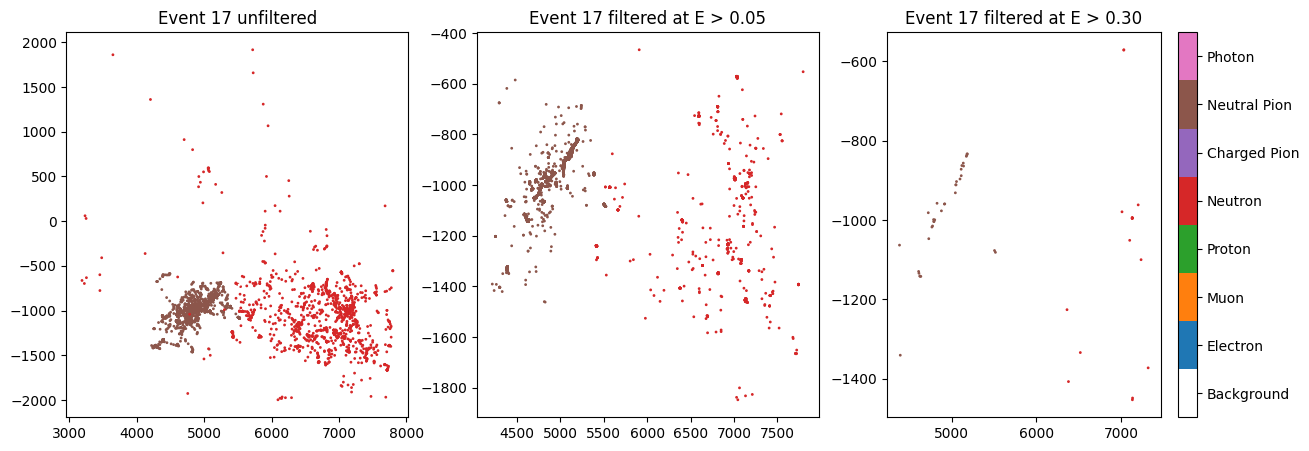

In [5]:
eid = 17
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
im = ax[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
ax[0].set_title(f"Event {eid} unfiltered")
mask &= edep > 0.05
im = ax[1].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
ax[1].set_title(f"Event {eid} filtered at E > 0.05")
mask &= edep > 0.30
im = ax[2].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
ax[2].set_title(f"Event {eid} filtered at E > 0.30")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

In [6]:
numu_files[100]

PosixPath('/home/roblesee/dune/hpst/data/sim_data/train/argon_cubic_production/argon_cubic_numu_production_711.h5')

In [7]:
data_file = nue_files[100]
with h5py.File(data_file, 'r') as file:
    cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    trueclasses = classes.copy()


    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

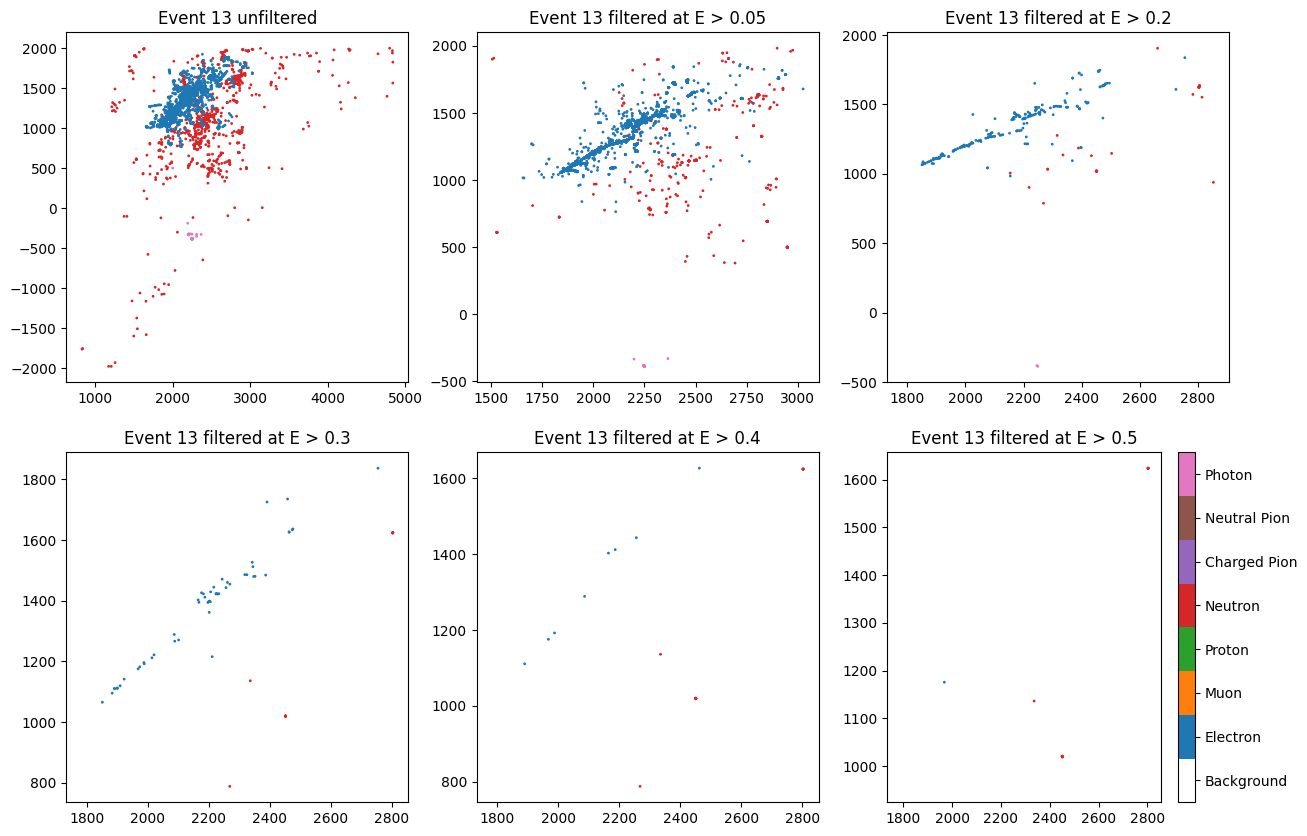

In [8]:
eid = 13
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

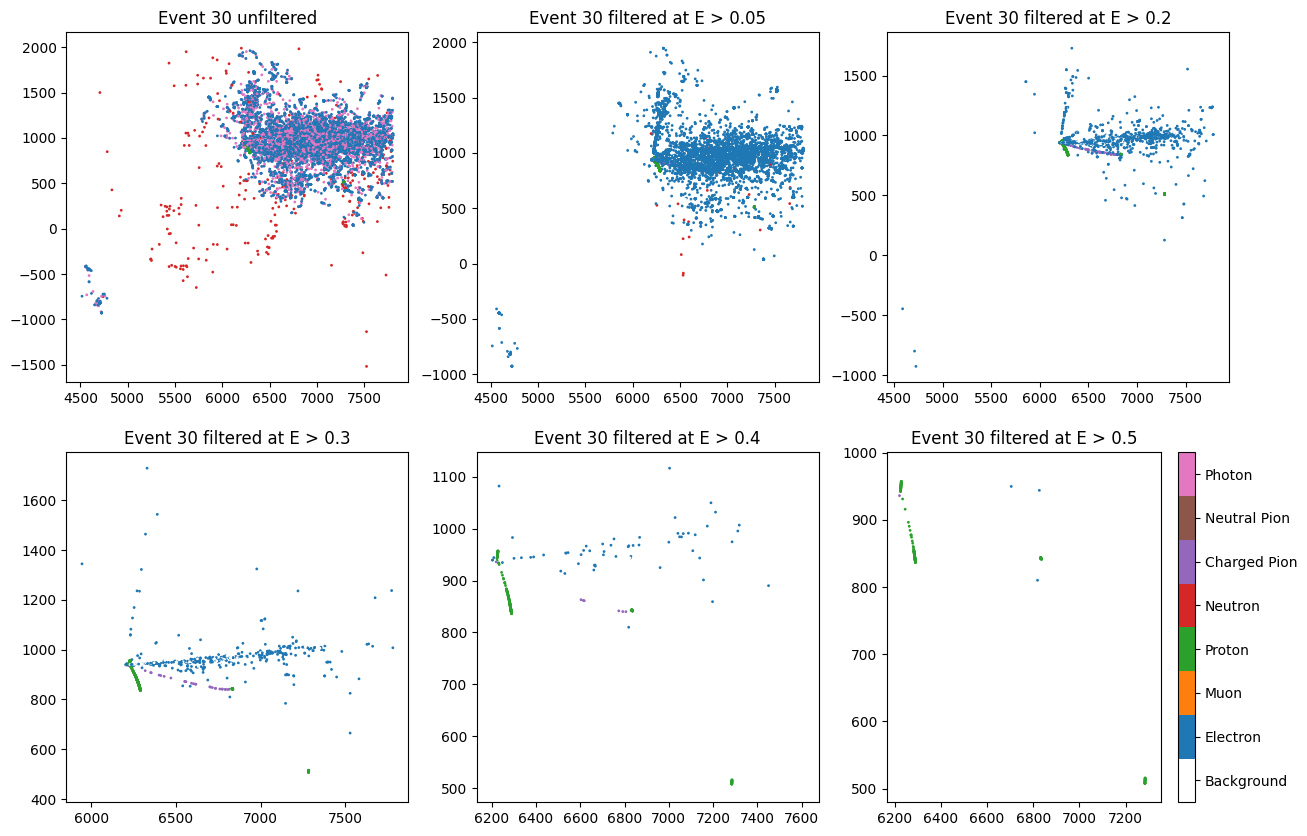

In [9]:
eid = 30
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

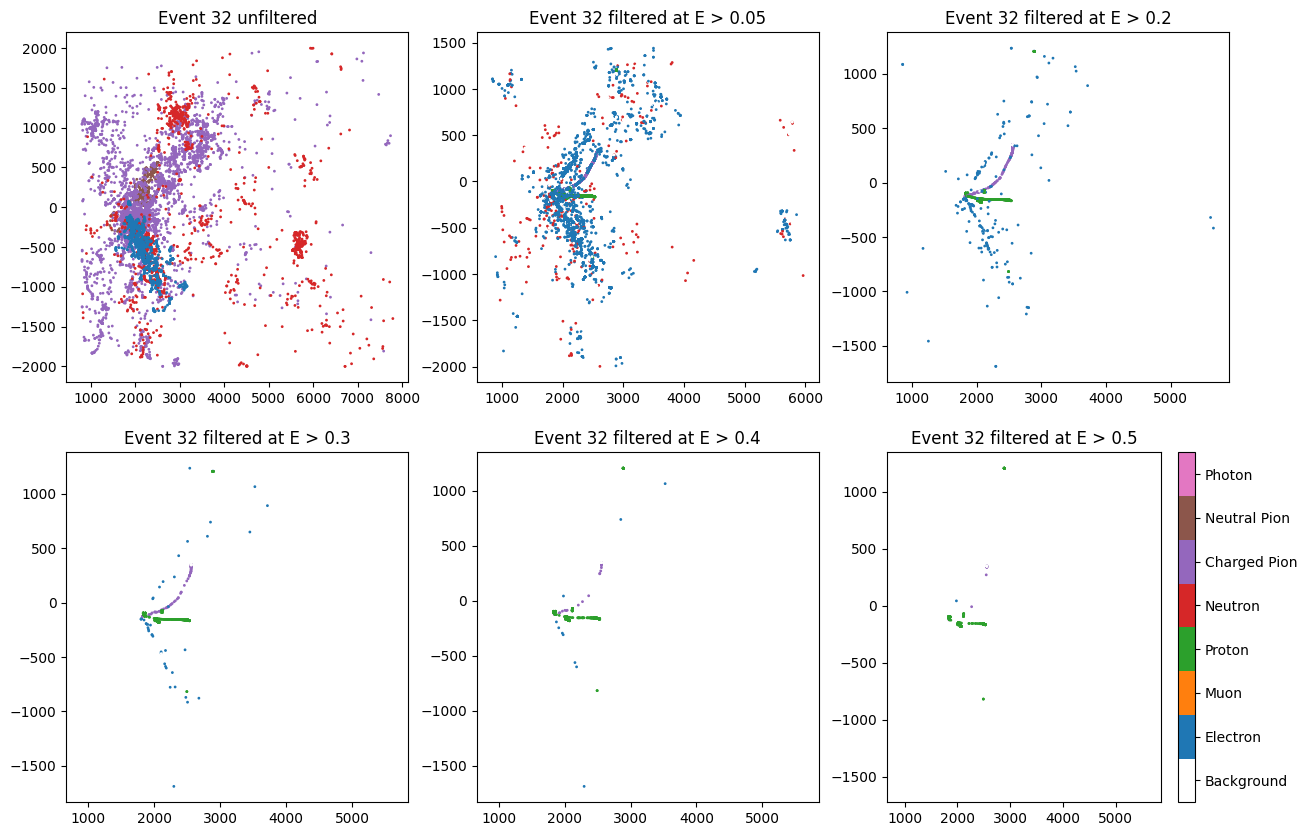

In [14]:
eid = 32
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

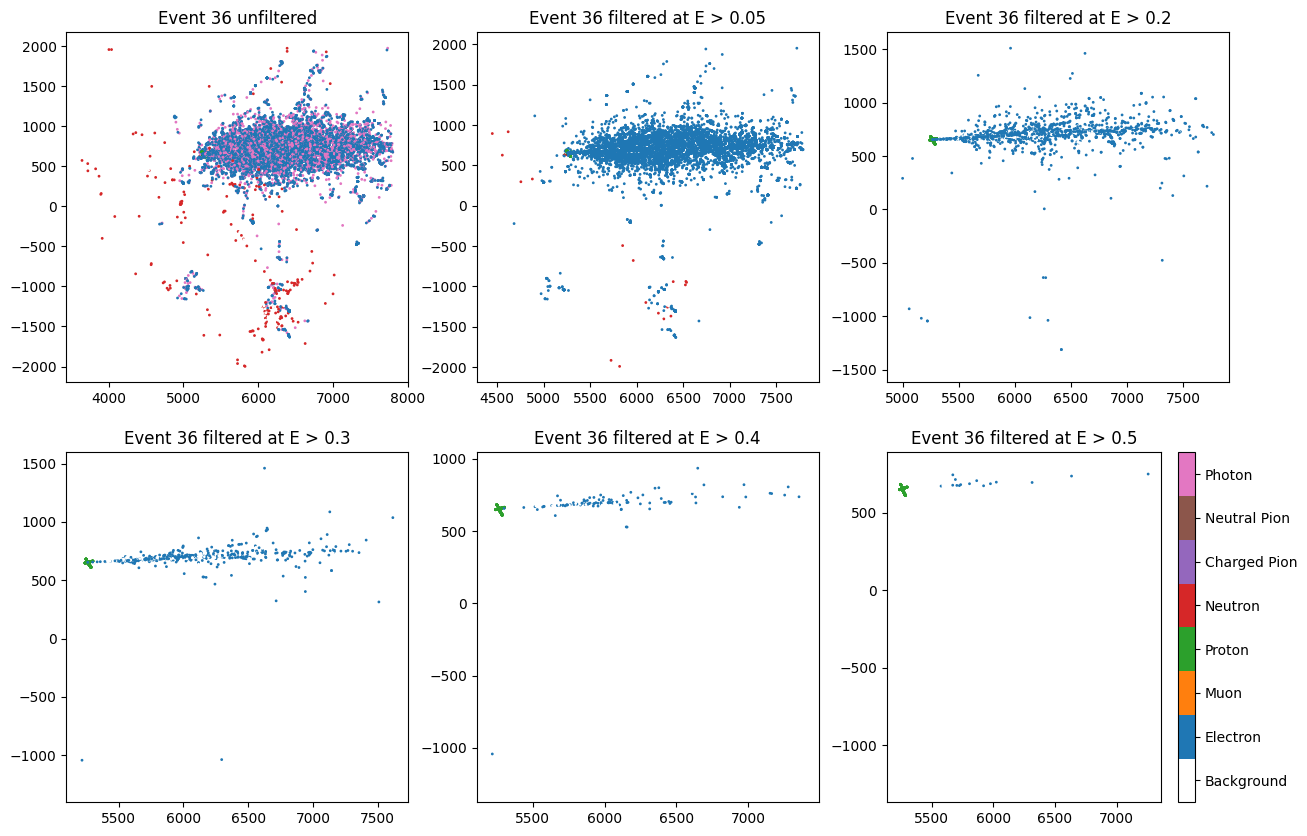

In [11]:
eid = 37

mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

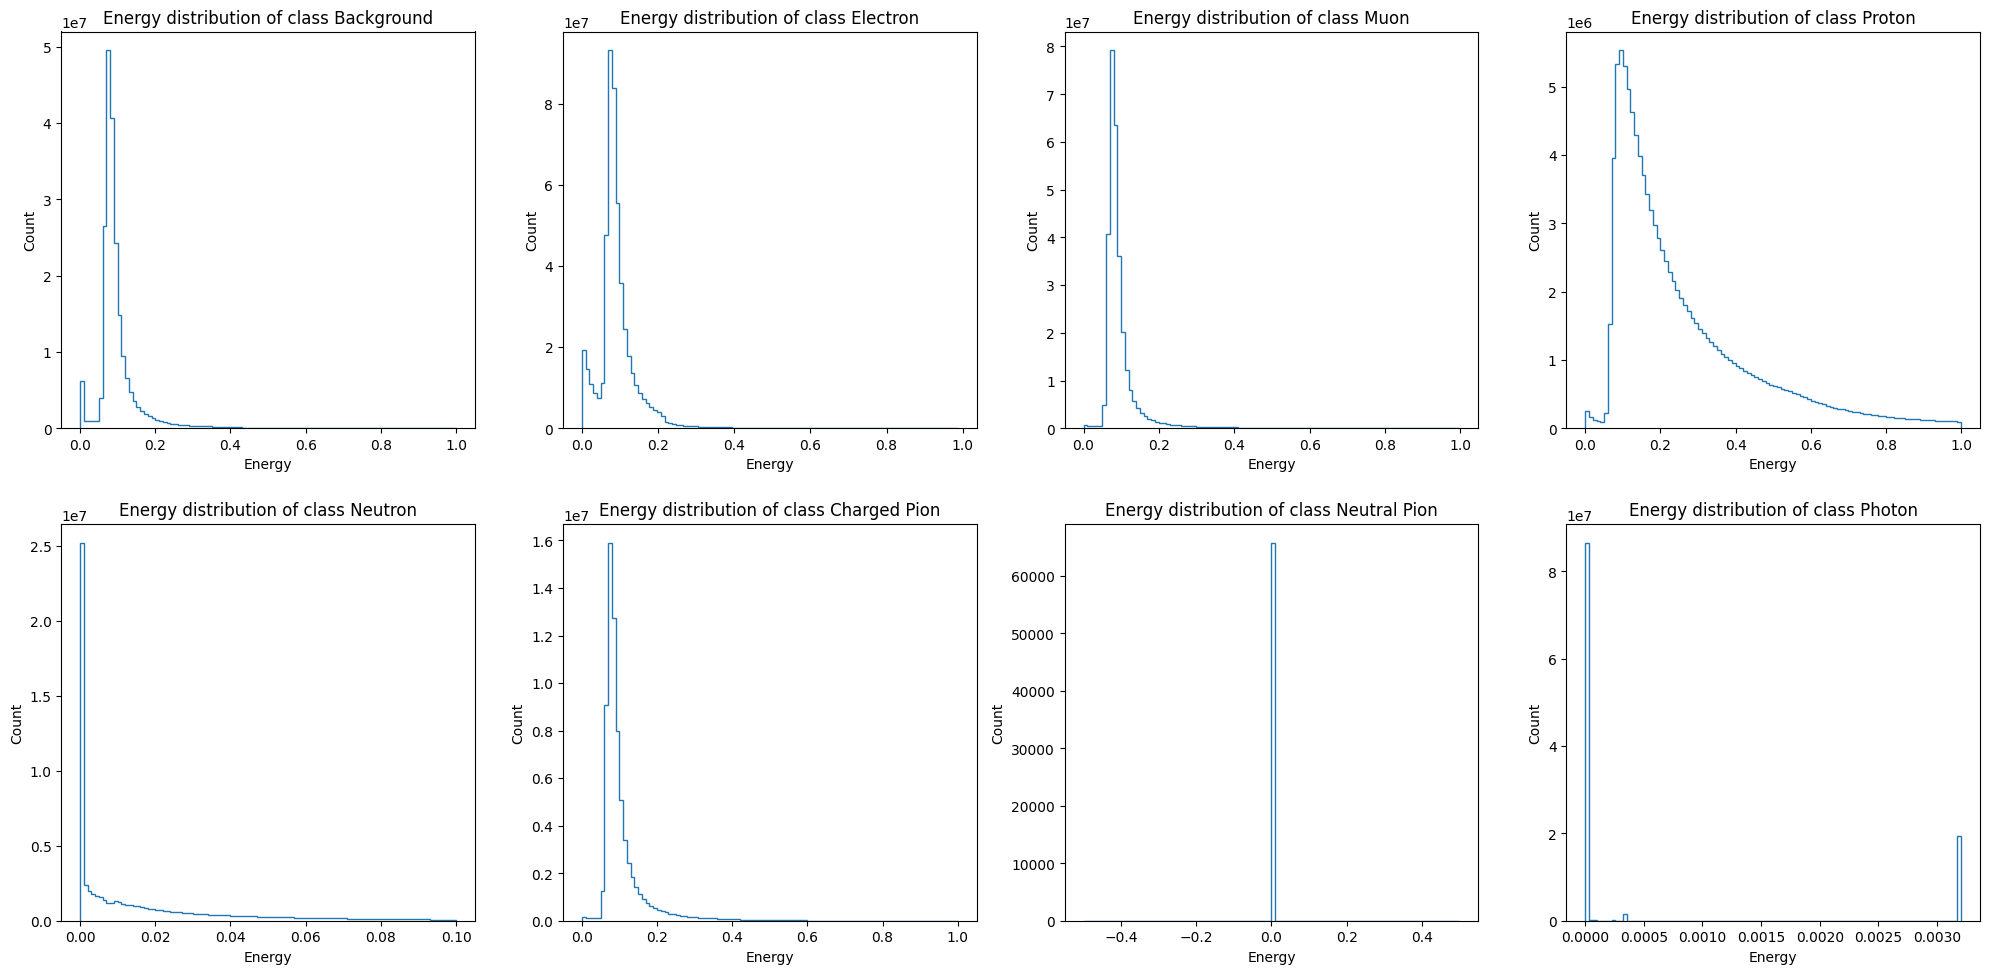

In [11]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"]
for c, ax in enumerate(axs.ravel()):
    mask = (numu_classes == c) & (numu_energies < 1) 
    ax.hist(numu_energies[mask], bins=100, histtype='step')
    ax.set_xlabel("Energy")
    ax.set_ylabel("Count")
    ax.set_title(f"Energy distribution of class {class_names[c]}")
plt.tight_layout()
plt.show()


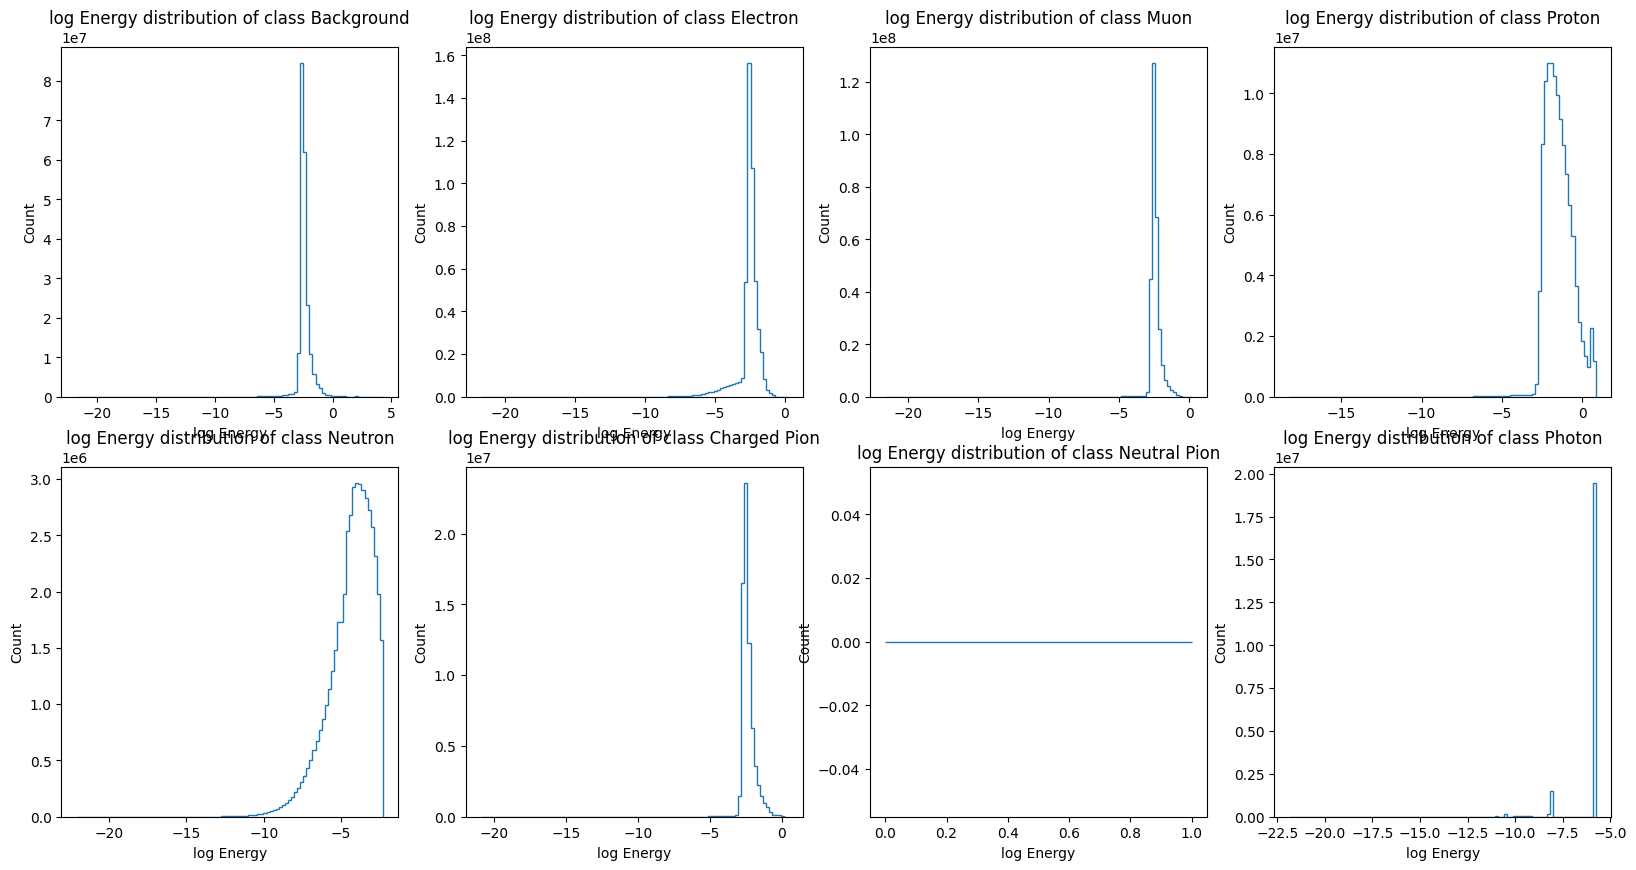

In [10]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"]
for c, ax in enumerate(axs.ravel()):
    mask = numu_classes == c
    log_energy = np.log(numu_energies[(numu_energies > 0) & mask])
    ax.hist(log_energy, bins=100, histtype='step')
    ax.set_xlabel("log Energy")
    ax.set_ylabel("Count")
    ax.set_title(f"log Energy distribution of class {class_names[c]}")
plt.show()

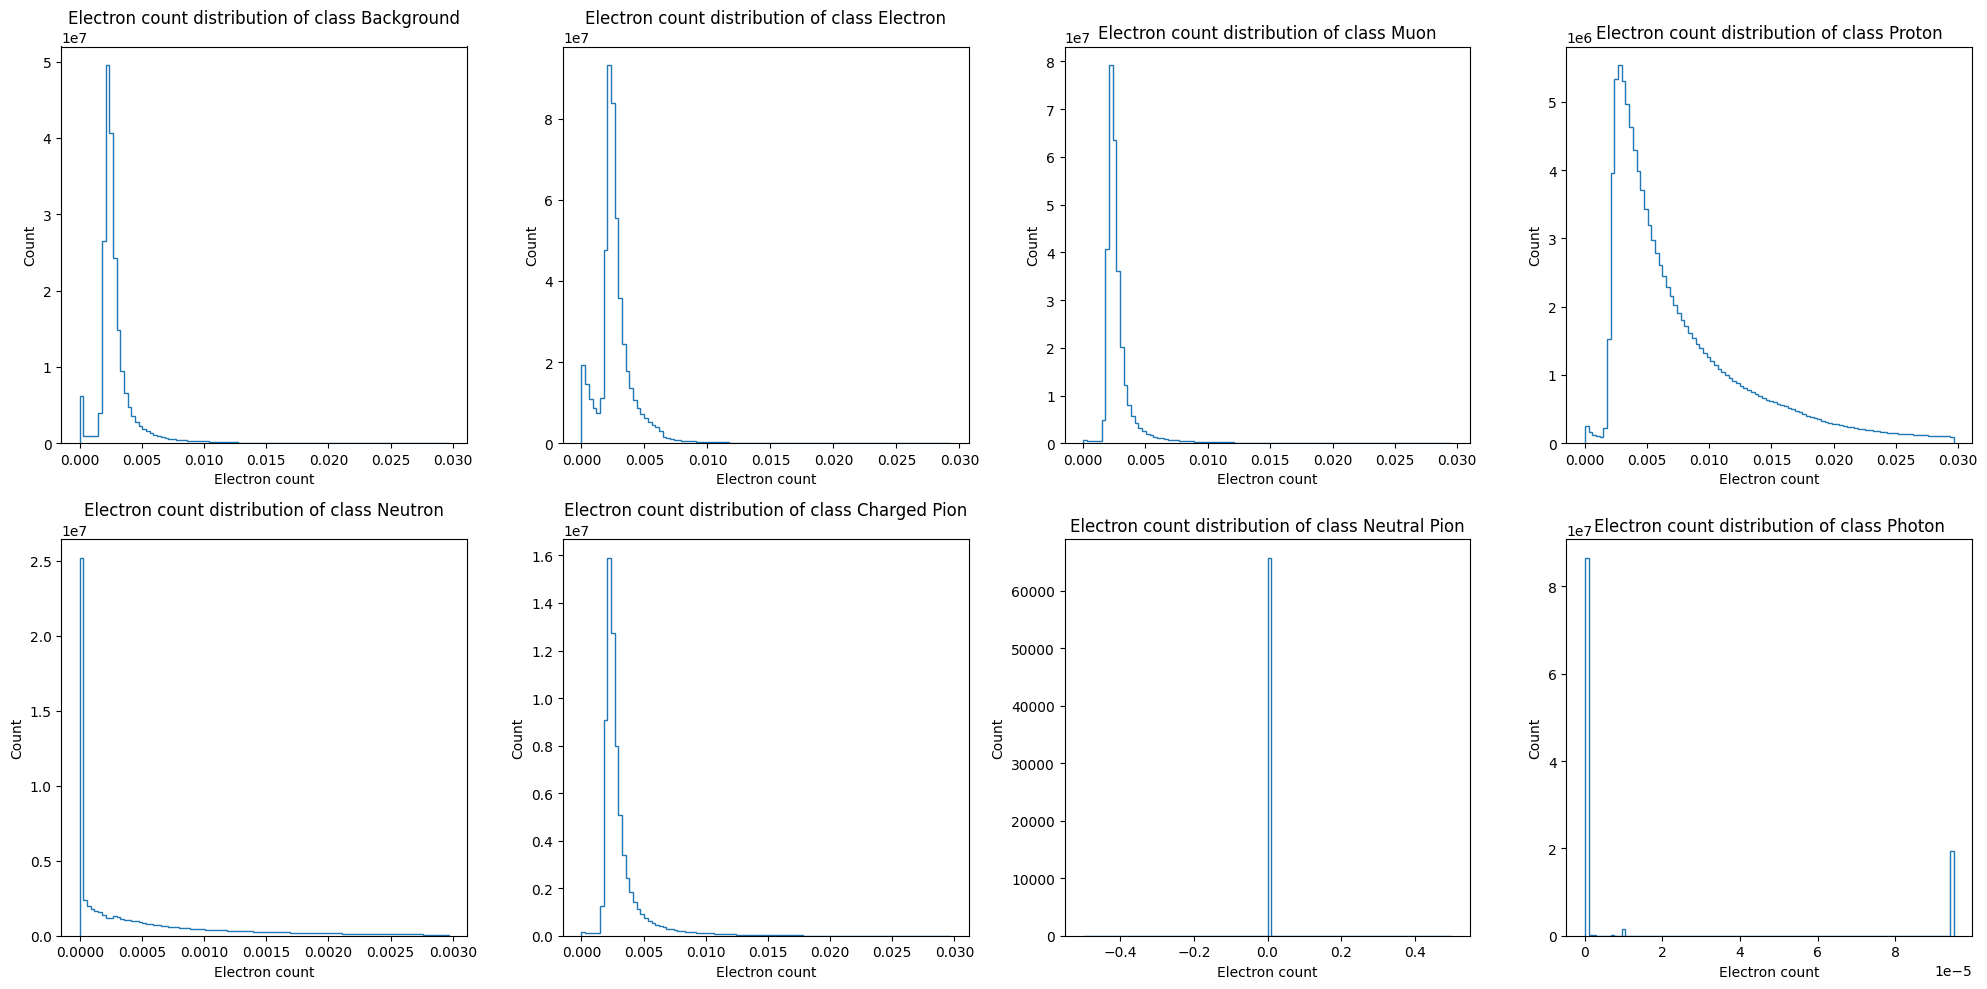

In [13]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"]
for c, ax in enumerate(axs.ravel()):
    mask = (numu_classes == c) & (numu_energies < 1)
    N_ei = (numu_energies/23.6)*0.7
    ax.hist(N_ei[mask], bins=100, histtype='step')
    ax.set_xlabel("Electron count")
    ax.set_ylabel("Count")
    ax.set_title(f"Electron count distribution of class {class_names[c]}")
plt.tight_layout()
plt.show()
